
* https://gymnasium.farama.org/tutorials/training_agents/reinforce_invpend_gym_v26/


论文：

[1] Williams, Ronald J.. “Simple statistical gradient-following algorithms for connectionist reinforcement learning.” Machine Learning 8 (2004): 229-256.  [PDF 链接](https://people.cs.umass.edu/~barto/courses/cs687/williams92simple.pdf)



REINFORCE：
* 是最早的策略梯度方法之一。
* 先学习一个价值函数再推导出一个策略 ——> REINFORCE 算法直接对策略进行优化。换句话说，它被训练成最大化 **蒙特卡洛回报的概率**。




## 环境： InvertedPendulum-v4

https://gymnasium.farama.org/environments/mujoco/inverted_pendulum/


这个环境包括一辆可以线性移动的车，它的一端固定着一根杆子，另一端自由移动。

小车可以向左或向右推，目标是通过**对小车施加力来平衡小车顶部的杆子**。

训练目标： 平衡推车顶部的杆(倒立摆)




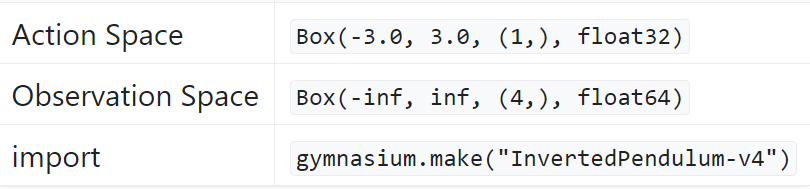

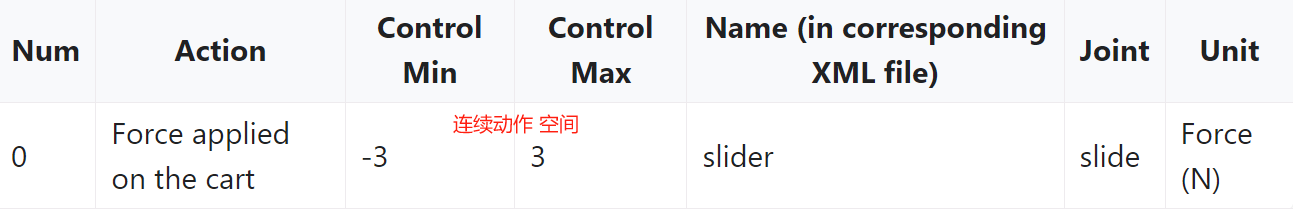

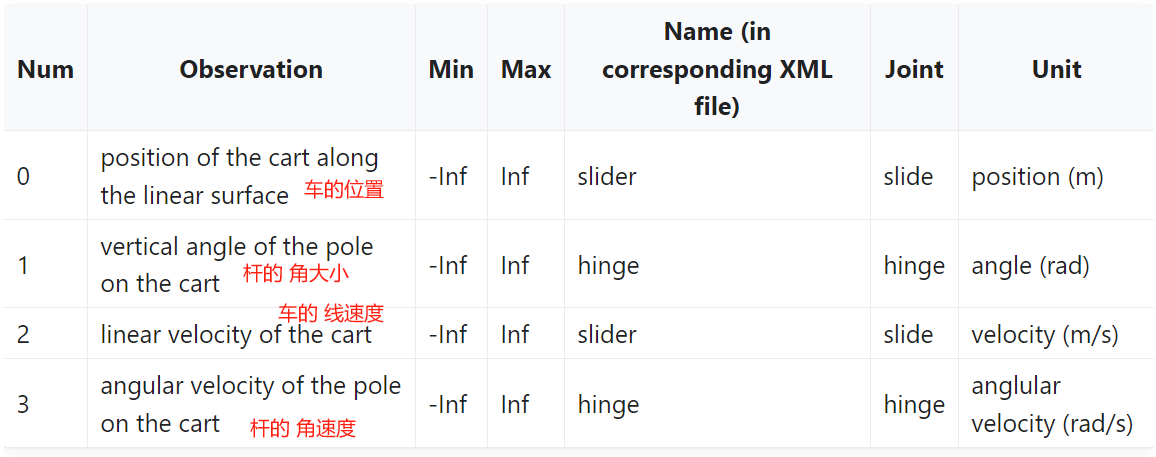

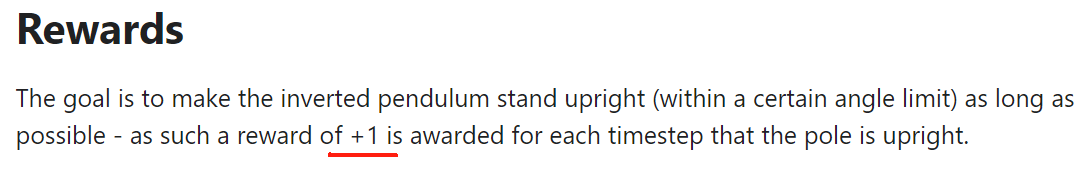

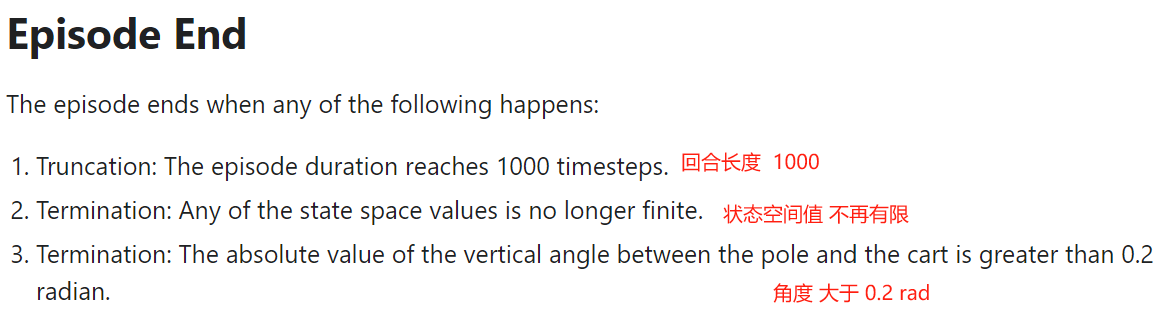

In [ ]:
!pip install gymnasium

In [ ]:
!pip install gymnasium[mujoco]

In [ ]:
import gymnasium as gym
env = gym.make('InvertedPendulum-v4')
print("reward_threshold:  ", env.spec.reward_threshold)

reward_threshold:   950.0


## 算法

In [ ]:
from __future__ import annotations

import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from torch.distributions.normal import Normal
from tqdm import tqdm # 循环模块 进度条显示

import gymnasium as gym

plt.rcParams["figure.figsize"] = (10, 5)

### 策略 网络

我们首先建立一个策略，智能体将通过 REINFORCE 来学习。

策略是从当前环境观察到要采取的行动的概率分布的映射。

本教程中使用的策略由神经网络参数化。
* 它由 2 个线性层组成，在预测 平均值和标准差之间共享。
* 此外，单个线性层被用来估计 均值和标准差。
* `nn.Tanh` 用作隐藏层之间的非线性。

下面的函数估计正态分布的均值和标准差，从正态分布中抽取一个动作。

因此，期望策略能够根据当前观测值 学习输出均值和标准差的适当权重。

In [ ]:
class Policy_Network(nn.Module):
  """参数化 策略网络"""

  def __init__(self, obs_space_dims: int, action_space_dims: int):
    """初始化一个神经网络来估计 正态分布的平均值和标准差。动作从这个正态分布中采样。
    参数:
      obs_space_dims: 观测空间的维度
      action_space_dims: 动作空间的维度
    """
    super().__init__()

    hidden_space1 = 16  # 可以是 任意值
    hidden_space2 = 32  # 可以是 任意值

    # 共享网络
    self.shared_net = nn.Sequential(
        nn.Linear(obs_space_dims, hidden_space1),
        nn.Tanh(),
        nn.Linear(hidden_space1, hidden_space2),
        nn.Tanh(),
    )

    # 仅计算 策略的均值的 线性层
    self.policy_mean_net = nn.Sequential(
        nn.Linear(hidden_space2, action_space_dims)
    )

    # 仅计算 策略的 标准差的 线性层
    self.policy_stddev_net = nn.Sequential(
        nn.Linear(hidden_space2, action_space_dims)
    )

  def forward(self, x: torch.Tensor)-> tuple[torch.Tensor, torch.Tensor]:
    """以观测值为条件，返回正态分布的平均值和标准差，
        动作从该正态分布中采样。
    参数:
      x:从环境上观察
    返回:
      Action_means: 正态分布的预测 均值
      Action_stddevs: 正态分布的预测 标准差
    """

    shared_features = self.shared_net(x.float())

    action_means = self.policy_mean_net(shared_features)
    action_stddevs = torch.log(
        1 + torch.exp(self.policy_stddev_net(shared_features))
    )

    return action_means, action_stddevs


### 创建一个 agent

现在我们已经完成了策略的构建，让我们来开发 REINFORCE ，使策略网络具有生命。

REINFORCE 算法见上图。如前所述，REINFORCE 的目标是最大化蒙特卡洛收益。

有趣的事实： REINFORCE  是 “ ‘RE’ward ‘I’ncrement ‘N’on-negative ‘F’actor times ‘O’ffset ‘R’einforcement times ‘C’haracteristic ‘E’ligibility 的缩写。

注意:超参数的选择是为了训练一个表现良好的智能体。没有进行广泛的超参数调优。


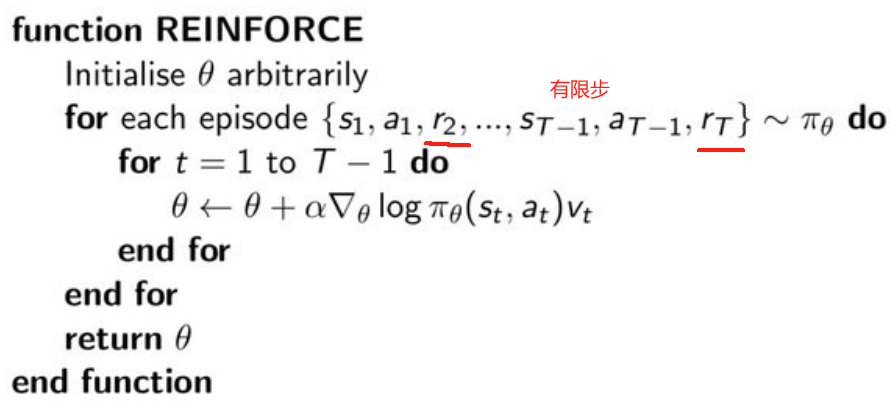

In [ ]:
class REINFORCE:
  """ REINFORCE 算法"""
  def __init__(self, obs_space_dims: int, action_space_dims: int):
    """初始化一个 通过 REINFORCE 算法[1]学习策略的代理来解决 Inverted Pendulum v4 任务。
    参数:
      obs_space_dims: 观察空间的维度
      action_space_dims: 动作空间的维度
    """

    # 超参数
    self.learning_rate = 1e-4  # 策略优化的 学习率
    self.gamma = 0.99  # 折扣率
    self.eps = 1e-6 # 数学稳定性的小数字

    self.probs = []  # 存储 执行某个动作的 概率值
    self.rewards = []  # 存储相应的 奖励

    self.net = Policy_Network(obs_space_dims, action_space_dims)
    self.optimizer = torch.optim.AdamW(self.net.parameters(), lr=self.learning_rate)


  def sample_action(self, state: np.ndarray) -> float:
    """根据 策略 和 观察， 返回一个动作。
    参数:
      state： 来自环境的观察。
    returns:
      action： 要执行的动作
    """
    state = torch.tensor(np.array([state]))
    action_means, action_stddevs = self.net(state)

    # 从预测中创建一个正态分布
    # 平均值 和 标准偏差  抽样一个动作
    distrib = Normal(action_means[0] + self.eps, action_stddevs[0] + self.eps)
    action = distrib.sample()
    prob = distrib.log_prob(action)

    action = action.numpy()
    self.probs.append(prob)

    return action

  def update(self):
    """更新 策略网络 的 权重"""
    running_g = 0
    gs = []

    for R in self.rewards[::-1]:
      running_g = R + self.gamma * running_g
      gs.insert(0, running_g)

    deltas = torch.tensor(gs)

    loss = 0
    # 最小化 -1 * prob * 获得的奖励
    for log_prob, delta in zip(self.probs, deltas):
      loss += log_prob.mean()* delta * (-1)

    # 更新 策略网络
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

    # 重置
    self.probs = []
    self.rewards = []


注意:在许多常见用例中，<mark>深度强化学习在随机种子方面相当脆弱</mark>

https://spinningup.openai.com/en/latest/spinningup/spinningup.html

因此，测试各种种子是很重要的，我们将会这样做。

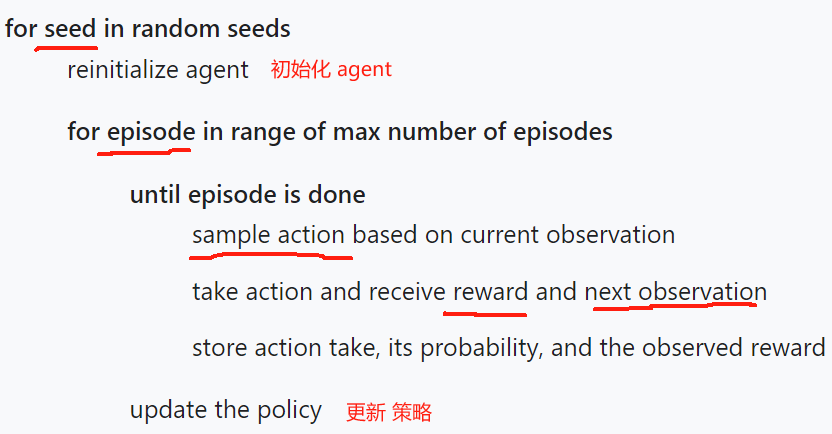

In [ ]:
# 创建 和 包装 环境

env = gym.make("InvertedPendulum-v4")
wrapped_env = gym.wrappers.RecordEpisodeStatistics(env, 50) # 记录 累积奖励 和 回合长度

total_num_episodes = int(5e3)  # 总的回合总数
obs_space_dims = env.observation_space.shape[0]
action_space_dims = env.action_space.shape[0]
rewards_over_seeds = []

for seed in [1, 2, 3, 5, 8]: # Fibonacci seeds  至少 3 个 seed, 可以 10 个甚至更多。
  # 设置 种子
  torch.manual_seed(seed)
  random.seed(seed)
  np.random.seed(seed)

  # 每个种子重新初始化 代理agent
  agent = REINFORCE(obs_space_dims, action_space_dims)
  reward_over_episodes = []

  for episode in range(total_num_episodes):
    # gymnasium v26 要求用户在重置环境时设置种子
    obs, info = wrapped_env.reset(seed=seed)

    done = False
    while not done:
      action = agent.sample_action(obs)
      obs, reward, terminated, truncated, info = wrapped_env.step(action)
      agent.rewards.append(reward)

      done = terminated or truncated

    reward_over_episodes.append(wrapped_env.return_queue[-1])
    agent.update()

    if episode % 1000 == 0:
      avg_reward = int(np.mean(wrapped_env.return_queue))
      print("Episode:", episode, "Average Reward: ", avg_reward)

  rewards_over_seeds.append(reward_over_episodes)


  0%|          | 0/5 [00:00<?, ?it/s]

Episode: 0 Average Reward:  8
Episode: 1000 Average Reward:  38
Episode: 2000 Average Reward:  83
Episode: 3000 Average Reward:  122
Episode: 4000 Average Reward:  153


 20%|██        | 1/5 [11:31<46:05, 691.46s/it]

Episode: 0 Average Reward:  201
Episode: 1000 Average Reward:  22
Episode: 2000 Average Reward:  61
Episode: 3000 Average Reward:  118
Episode: 4000 Average Reward:  175


 40%|████      | 2/5 [22:10<33:02, 660.84s/it]

Episode: 0 Average Reward:  223
Episode: 1000 Average Reward:  15
Episode: 2000 Average Reward:  36
Episode: 3000 Average Reward:  236
Episode: 4000 Average Reward:  888


 60%|██████    | 3/5 [56:47<43:34, 1307.31s/it]

Episode: 0 Average Reward:  836
Episode: 1000 Average Reward:  19
Episode: 2000 Average Reward:  48
Episode: 3000 Average Reward:  116
Episode: 4000 Average Reward:  376


 80%|████████  | 4/5 [1:17:06<21:12, 1272.31s/it]

Episode: 0 Average Reward:  910
Episode: 1000 Average Reward:  20
Episode: 2000 Average Reward:  69
Episode: 3000 Average Reward:  126
Episode: 4000 Average Reward:  242


100%|██████████| 5/5 [1:35:11<00:00, 1142.30s/it]


### 绘制 学习曲线

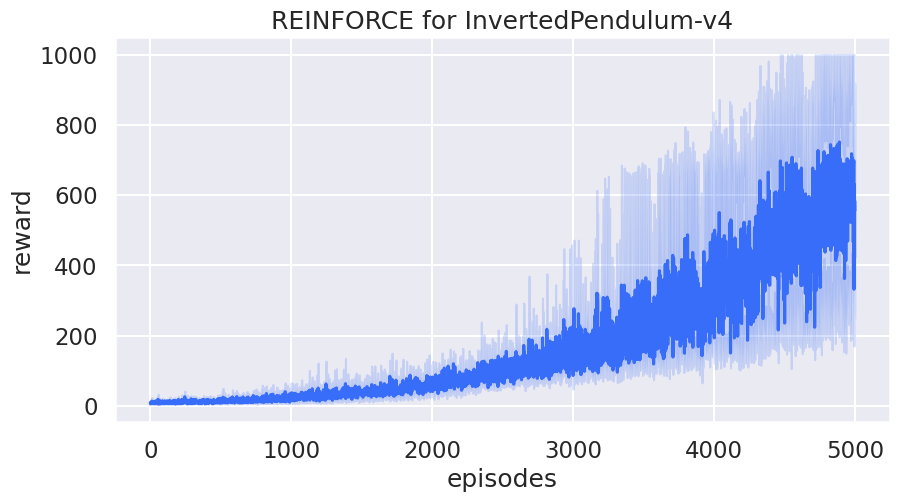

In [ ]:
rewards_to_plot = [[reward[0] for reward in rewards] for rewards in rewards_over_seeds]
df1 = pd.DataFrame(rewards_to_plot).melt()
df1.rename(columns={"variable": "episodes", "value": "reward"}, inplace=True)
sns.set(style="darkgrid", context="talk", palette="rainbow")
sns.lineplot(x="episodes", y="reward", data = df1).set(
    title="REINFORCE for InvertedPendulum-v4"
)
plt.show()